
#### Stage 1

In this stage, we are trying to predict whether the customer will buy in their current session or not. 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
#features selection and class imbalance
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
#machine learning models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
#model performance evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

In [2]:
train = pd.read_csv('final_session_level_train.csv')
test = pd.read_csv('final_session_level_test.csv')

In [3]:
train.head(10)

,Unnamed: 0,Session ID,num_clicks_session,buy_flag,session_length,Avg_time_bet_clicks,Max_time_bet_clicks,unique_items,max_click_per_item,max_hour,max_day,max_month,Avg_item_price,Popularity,perc_prod_offer,perc_prod_no_cat,perc_prod_pop
0,0,1,4,False,351.0,116.666667,180.0,4,1,10,0,4,2669.000000,0.020006,0.0,1.0,0.500000
1,1,2,6,False,359.0,71.400000,118.0,5,2,14,0,4,2382.333333,0.006365,0.0,1.0,0.800000
2,2,3,3,False,745.0,372.000000,495.0,3,1,13,2,4,4701.595023,0.026714,0.0,1.0,0.000000
3,3,4,2,False,1034.0,1034.000000,1034.0,2,1,12,0,4,20315.500000,0.006692,0.0,1.0,0.500000
4,4,6,2,False,246.0,246.000000,246.0,2,1,17,6,4,6336.696891,0.025385,0.0,1.0,0.000000
5,5,7,2,False,12.0,12.000000,12.0,2,1,6,2,4,1206.662927,0.078417,0.0,1.0,0.000000
6,6,8,2,False,133.0,133.000000,133.0,1,2,8,6,4,2303.000000,0.120482,0.0,1.0,0.000000
7,7,9,3,False,169.0,84.000000,150.0,1,3,11,6,4,1674.000000,0.023930,0.0,1.0,0.000000
8,8,11,12,True,783.0,71.000000,385.0,9,3,10,3,4,990.447912,0.021625,0.0,1.0,0.333333
9,9,12,2,True,179.0,179.000000,179.0,1,2,10,2,4,1749.868852,0.022427,0.0,1.0,0.000000


When inspecting the dataset, we observed that we need to transform the buy_flag feature to numerical values before running our model. We also dropped columns that will not be needed later on. 

In [4]:
#preprocessing data
buy = pd.get_dummies(train['buy_flag'], drop_first=True) 
train = pd.concat([train, buy], axis=1)
train.columns = [*train.columns[:-1], 'Buy']

buy = pd.get_dummies(test['buy_flag'], drop_first=True) 
test = pd.concat([test, buy], axis=1)
test.columns = [*test.columns[:-1], 'Buy']

rmv_col = ['buy_flag', 'Unnamed: 0', 'Session ID']
train = train.drop(rmv_col, axis=1)
test = test.drop(rmv_col, axis=1)

## Full Dataset

As observed below, our data is highly imbalanced, with 95% of data classified as class 0 and 5% of data classified as class 1. We will need to address this when running our model, either by specifying in the parameters or performing different sampling techniques, such as over-sampling or under-sampling to balance the data.

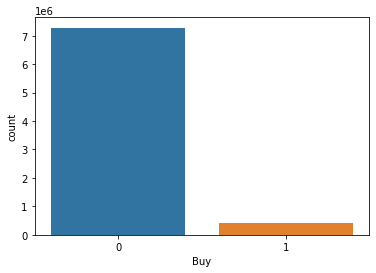

In [5]:
sns.countplot(x = 'Buy', data=train)

Here, we will split the full dataset into training and testing set. 

In [6]:
X_train = train.drop("Buy", axis=1)
y_train = train["Buy"]

X_test = test.drop("Buy", axis=1)
y_test = test["Buy"] 

We will compare the performances of 8 different models: Logistic Regression, XGBoost, Support Vector Machine (SVM), Neural Networks, CatBoost, Light GBM, and Stack Generalizer on the sample dataset. On the full dataset, we will implement Logistic Regression, XGBoost, CatBoost, and SVM. 

### 1. Logistic Regression

Here, we will train the Logistic Regression model on the entire dataset.

In [7]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
logit_model = sm.Logit(y_train,X_train)
result = logit_model.fit()
print(result.summary2())

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                           Results: Logit
Model:                  Logit              Pseudo R-squared:   inf   
Dependent Variable:     Buy                AIC:                inf   
Date:                   2021-06-09 17:38   BIC:                inf   
No. Observations:       7710267            Log-Likelihood:     -inf  
Df Model:               13                 LL-Null:            0.0000
Df Residuals:           7710253            LLR p-value:        1.0000
Converged:              1.0000             Scale:              1.0000
No. Iterations:         8.0000                                       
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
num_clicks_session   0.0617   0.0014   43.0761 0.0000  0.0589  0.0645
session_length       0.0001   0.0000   34.5262 0.0000  0.0001  0.0001
Avg_time_bet_clicks  0.0001   0.0000    7.9507 0

As unique_items has a p-value greater than 0.05, which indicates that this feature is not significant, we will drop it from our dataset.

In [9]:
X_train = X_train.drop("unique_items", axis=1)
X_test= X_test.drop("unique_items", axis=1)

We apply SMOTE to handle class imbalance before training our model. 

In [10]:
os = SMOTE(random_state = 42, n_jobs=-1)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns)
os_data_y = pd.DataFrame(data = os_data_y,columns = ['Buy'])

print("length of oversampled data is ",len(os_data_X))
print("Number of no default in oversampled data",len(os_data_y[os_data_y['Buy'] == 0]))
print("Number of default",len(os_data_y[os_data_y['Buy'] == 1]))
print("Proportion of no default data in oversampled data is ",len(os_data_y[os_data_y['Buy'] == 0])/len(os_data_X))
print("Proportion of default data in oversampled data is ",len(os_data_y[os_data_y['Buy'] == 1])/len(os_data_X))

length of oversampled data is  14563364
Number of no default in oversampled data 7281682
Number of default 7281682
Proportion of no default data in oversampled data is  0.5
Proportion of default data in oversampled data is  0.5


In [11]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
y_pred = logreg.predict(X_test)

We generate the ROC Curve to find the optimal threshold where our model will achieve highest performance.

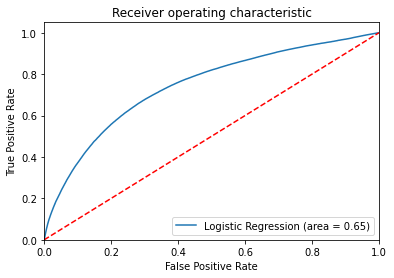

In [14]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.38466641164306037


In [16]:
THRESHOLD = optimal_threshold
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

(1028696, 429655, 26610, 54501)

In [17]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82   1458351
           1       0.11      0.67      0.19     81111

    accuracy                           0.70   1539462
   macro avg       0.54      0.69      0.51   1539462
weighted avg       0.93      0.70      0.79   1539462



### 2. XGBoost

Here, we applied XGBoost to the full dataset. Ideally, we would want to tune the following parameters: 
1. *n_estimators*: number of estimators when boosting is terminated. 
2. *max_depth*: maximum depth of a tree. Higher value can make the tree overfit
3. *gamma*: minimum loss reduction required to make partition on a leaf node of the tree. the higher value of gamma, the more conservative the algorithm will be

However, since *GridSearchCV* performs exhaustive search over specified parameter values, it will take hours, if not days, for it to finish tuning our parameters given our laptop are not of the professionals. Therefore, in the interest of time, we will specify these parameters manually. Below is the codes for which we will use to tune our parameters.

In [ ]:
## XGB - number of estimators
param_test = {'n_estimators': range(50, 500, 50)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', scale_pos_weight = 18, learning_rate=0.2, 
                                                  use_label_encoder =False, eval_metric = 'auc'), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

In [ ]:
## XGB - maximum tree depth
param_test2 = {'max_depth':range(1,10,2)}
gsearch2 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', scale_pos_weight = 18,
                                                  n_estimators = gsearch1.best_params_['n_estimators'], 
                                                  learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc'), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch2.fit(X_train, y_train)
gsearch2.best_params_

In [ ]:
#tuning gamma parameter
param_test3 = {'gamma': [i/10.0 for i in range(0,5)]} 
gsearch3 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', scale_pos_weight = 18,
                                                  n_estimators = gsearch1.best_params_['n_estimators'], 
                                                  learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                  max_depth = gsearch2.best_params_['max_depth']), 
                        param_grid = param_test3, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch3.fit(X_train, y_train)
gsearch3.best_params_

In [ ]:
## Tuned model
XGB_model = XGBClassifier(objective='binary:logistic', scale_pos_weight = 18, n_estimators = gsearch1.best_params_, 
                          max_depth = gsearch2.best_params_, gamma = gsearch3.best_params_, 
                          scale_pos_weight = 17, n_jobs=-1, learning_rate = 0.2, 
                          #we need to account for imbalance class ratio 1:17.98 using scale_pos_weight
                          use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(X_train, y_train)
XGB_model_predict = XGB_model.predict(X_test)
XGB_model

We will then specify the parameters manually: 
1. *n_estimators*: 50 as a value that would work well given the power of our system
2. *max_depth*: as the default is 6 and increasing this value will make the model more complex and overfit, we will go with 7
3. *gamma*: the default value is 0 and increasing it will make the algorithm more conservative. Thus, we want to start at a smaller value like 0.1 and can alter it later on if required
4. *scale_pos_weight*: since the ratio between class 0 and 1 is 18, we will specify this value for this parameter

In [67]:
#full dataset split
X_train = train.drop("Buy", axis=1)
y_train = train["Buy"]

X_test = test.drop("Buy", axis=1)
y_test = test["Buy"] 

In [68]:
## Tuned model
XGB_model = XGBClassifier(objective='binary:logistic', n_estimators = 50, 
                          scale_pos_weight = 18, n_jobs=-1, learning_rate = 1, alpha = 0.1,
                          #we need to account for imbalance class ratio 1:17.98 using scale_pos_weight
                          use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(X_train, y_train)
XGB_model_predict = XGB_model.predict(X_test)
XGB_model

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.100000001,
              reg_lambda=1, scale_pos_weight=18, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [69]:
print('XGB Test Accuracy:', accuracy_score(y_test, XGB_model_predict), '\n')
print(classification_report(y_test, XGB_model_predict))
print(confusion_matrix(y_test, XGB_model_predict), '\n')

XGB Test Accuracy: 0.9217427906632317 

              precision    recall  f1-score   support

           0       0.95      0.96      0.96   1458351
           1       0.20      0.16      0.18     81111

    accuracy                           0.92   1539462
   macro avg       0.58      0.56      0.57   1539462
weighted avg       0.91      0.92      0.92   1539462

[[1405785   52566]
 [  67908   13203]] 



Observing the results above, our parameters will need further tuning to be able to classify class 1 better. We chose to add a booster called 'gblinear', which uses linear functions instead of the default 'gbtree', which uses tree based model. We chose linear functions since logistic regression and SVM, which are both linear classifiers, seem to work well on this dataset. 

In [70]:
## Tuned model
XGB_model = XGBClassifier(objective='binary:logistic', n_estimators = 50, booster = 'gblinear',
                          scale_pos_weight = 18, n_jobs=-1, learning_rate = 1, alpha = 0.1,
                          #we need to account for imbalance class ratio 1:17.98 using scale_pos_weight
                          use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(X_train, y_train)
XGB_model_predict = XGB_model.predict(X_test)
XGB_model

XGBClassifier(alpha=0.1, base_score=0.5, booster='gblinear',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, eval_metric='auc', gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=18,
              subsample=None, tree_method=None, use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [71]:
print('XGB Test Accuracy:', accuracy_score(y_test, XGB_model_predict), '\n')
print(classification_report(y_test, XGB_model_predict))
print(confusion_matrix(y_test, XGB_model_predict), '\n')

XGB Test Accuracy: 0.7437695766443082 

              precision    recall  f1-score   support

           0       0.97      0.75      0.85   1458351
           1       0.13      0.64      0.21     81111

    accuracy                           0.74   1539462
   macro avg       0.55      0.70      0.53   1539462
weighted avg       0.93      0.74      0.81   1539462

[[1092744  365607]
 [  28850   52261]] 



### 3. CatBoost

Here, we applied CatBoost to the full dataset. 

In [22]:
#full dataset split
X_train = train.drop("Buy", axis=1)
y_train = train["Buy"]

X_test = test.drop("Buy", axis=1)
y_test = test["Buy"] 

Similar to our reasoning for XGBoost above, we will manually specify the parameters for this model:
1. *iterations*: 50 as a good value for our computer performance
2. *class_weights*: given the ratio between class 0 and 1 at 1:18, we will specify this in our model

In [23]:
ctb = CatBoostClassifier(eval_metric='AUC', learning_rate = 0.2, class_weights={0: 1, 1: 18}, iterations=50)
ctb.fit(X_train, y_train)
y_pred = ctb.predict(X_test)

0:	total: 862ms	remaining: 42.3s
1:	total: 1.58s	remaining: 37.8s
2:	total: 2.28s	remaining: 35.7s
3:	total: 3s	remaining: 34.4s
4:	total: 3.74s	remaining: 33.7s
5:	total: 4.47s	remaining: 32.8s
6:	total: 5.14s	remaining: 31.6s
7:	total: 5.87s	remaining: 30.8s
8:	total: 6.56s	remaining: 29.9s
9:	total: 7.18s	remaining: 28.7s
10:	total: 7.82s	remaining: 27.7s
11:	total: 8.48s	remaining: 26.9s
12:	total: 9.15s	remaining: 26s
13:	total: 10.1s	remaining: 25.9s
14:	total: 11.1s	remaining: 25.9s
15:	total: 12.2s	remaining: 25.8s
16:	total: 13.2s	remaining: 25.6s
17:	total: 14s	remaining: 24.9s
18:	total: 14.9s	remaining: 24.3s
19:	total: 15.8s	remaining: 23.6s
20:	total: 16.7s	remaining: 23s
21:	total: 17.7s	remaining: 22.5s
22:	total: 18.7s	remaining: 21.9s
23:	total: 19.8s	remaining: 21.5s
24:	total: 20.8s	remaining: 20.8s
25:	total: 21.8s	remaining: 20.1s
26:	total: 22.6s	remaining: 19.2s
27:	total: 23.3s	remaining: 18.3s
28:	total: 24.1s	remaining: 17.5s
29:	total: 24.9s	remaining: 16.6s

In [25]:
print(ctb.get_all_params())
print(classification_report(y_test, y_pred), '\n')

{'nan_mode': 'Min', 'eval_metric': 'AUC', 'iterations': 50, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 18], 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'learning_rate': 0.20000000298023224, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimati

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(1458309, 42, 81095, 16)

As observed above, CatBoost does not work well in the full dataset compare to its performance in the sample dataset. Additionally, it does not allow us to specify between tree based model and linear functions. Thus, we were unable to improve on its performance. This is one of the reasons why XGBoost is so popular given its flexibility in using both linear model and tree learning algorithms.

As Light GBM is a similar method to CatBoost and XGBoost, while not having the flexibility as XGBoost in specifying the linear functions. It only allows to choosing tree-based methods, such as random forest, gradient boosting decision tree, etc, as boosting types. Thus, we decided to not run it on the full dataset. 

### 4. Support Vector Machine (SVM)

Here, we apply SVM to our full dataset. Similar to our reasoning for XGBoost and CatBoost, we will manually specify the parameters for our model:
1. *max_iter*: the default maximum number of passes over training data is 1000. However, in the interest of time and computer limitations, we will use 100 
2. *loss*: we used hinge as it is a loss function typically used for training classifiers
3. *penalty*: we used l1 as our regularisation term as it might bring sparsity in our model by shrinking some feature coefficients to 0, which helps reducing its complexity while still reducing the model's variance
4. *class_weight*: even though our actual ratio is 1:18, after testing with a few weights, we found that 1:36 gives us better performance results. This means that we need to give twice the weight from the original ratio to class 1
5. *alpha*: given that the default is 0.0001 and the higher the value, the stronger the regularisation, we chose alpha value at 0.01 so that it will penalises more when there is a misclassification

In [19]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)
clf = SGDClassifier(loss='hinge', penalty='l1', n_jobs=-1, class_weight={0: 1, 1: 36}, max_iter=100,
                   alpha=0.01)
clf.fit(SVM_Xtrain, y_train)

SGDClassifier(alpha=0.01, class_weight={0: 1, 1: 36}, max_iter=100, n_jobs=-1,
              penalty='l1')

In [20]:
y_pred = clf.predict(SVM_Xtest)
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

              precision    recall  f1-score   support

           0       0.97      0.76      0.85   1458351
           1       0.13      0.64      0.21     81111

    accuracy                           0.75   1539462
   macro avg       0.55      0.70      0.53   1539462
weighted avg       0.93      0.75      0.82   1539462



(1103971, 354380, 29588, 51523)

### Summary

As observed above, when implementing the models to the full dataset, the performance between each varies significantly. CatBoost does terrible, while Logistic Regression, XGBoost and SVM do much better. As Logistic Regression and XGBoost have slightly better performance than SVM, we will implement these two methods in our final results and compare the scoring. 

------------------------------------------------------------------------------------------------------------------------------

## Sample Data - Model Performance Comparison

As we have a large dataset, we will compare model performance based on a small subset of data. In this case, we will use latest month data to run our models, make predictions, and compare performances. In this case, we will split the test_data, which also is latest 1-month data, into training set and testing set using 75:25 ratio. 

Here, we also observed the highly imbalanced ratio between class 0 and class 1, which helps when training the models as it mimics the issue we have observed in the full dataset.

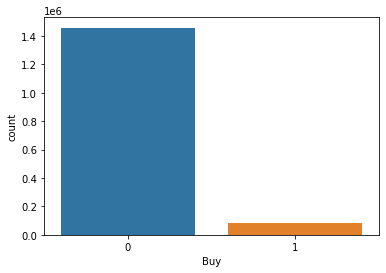

In [72]:
sns.countplot(x = 'Buy', data=test)

### 1. Logistic Regression

Logistic Regression is a discriminative classifier that uses a linear regression model to represent the probability through a logistic function in matrix notation: 
\begin{equation}
p(X) = \frac{exp(w^Tx)}{1+exp(w^Tx)}
\end{equation}
where $w^T$ represents the matrix for coefficients for each feature and x represents the observations. 

Logistic regression is popular machine learning method for binary classification. While simple, it gives good accuracy and has low training time. Additionally, it outputs a probability of the event being classified as class 0 or 1, which can then be adjusted using different threshold values depending on our classification purpose. For example, if the cost of misclassifying class 1 is too high, we would want to have a higher recall rate for class 1, thus we can do so by increasing the threshold value for the model to classify obsevation as class 1.  

In [18]:
#splitting data into training and test set
X = test.drop("Buy", axis=1)
y = test["Buy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

While there are many features selection method, we use Recursive Feature Elimination method, which selects the most significant features by recursively considering smaller sets of features. The least important features are pruned from the current set of features and this process is repeated. 

In [19]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


From the results above, all features are considered important so we will not need to remove any of them.

In [20]:
logit_model = sm.Logit(y_train,X_train)
result = logit_model.fit()
print(result.summary2())

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 9


/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                            Results: Logit
Model:                 Logit               Pseudo R-squared:    inf   
Dependent Variable:    Buy                 AIC:                 inf   
Date:                  2021-06-09 17:42    BIC:                 inf   
No. Observations:      1154596             Log-Likelihood:      -inf  
Df Model:              13                  LL-Null:             0.0000
Df Residuals:          1154582             LLR p-value:         1.0000
Converged:             1.0000              Scale:               1.0000
No. Iterations:        9.0000                                         
----------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------
num_clicks_session  -0.0170   0.0035   -4.8243 0.0000  -0.0238 -0.0101
session_length       0.0000   0.0000    3.2503 0.0012   0.0000  0.0001
Avg_time_bet_clicks  0.0002   0.00

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


As Popularity has p-value greater than 0.05, it is considered insignificant, so we will remove it from our dataset. 

In [21]:
X_train = X_train.drop("Popularity", axis=1)
X_test= X_test.drop("Popularity", axis=1)

We then address the issue of class imbalance in our dataset using the Synthetic Minority Over-Sampling Technique (SMOTE), which creates synthetic samples from minor class instead of simply creating copies. It works by randomly chooses one of the K-nearest-neighbours and use it to create similar but randomly tweaked, new observations. 

There are different opinions over whether we should eliminate features before or after SMOTE. The argument given is that SMOTE can induce bias and it violates the independence assumption as it uses KNN technique, which implies that there are relationships between these features. In our case, we know that these features are somewhat related to each other as they are generated from the same dataset, we chose to apply RFE before SMOTE.  

In [22]:
os = SMOTE(random_state = 42, n_jobs=-1)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns)
os_data_y = pd.DataFrame(data = os_data_y,columns = ['Buy'])

print("length of oversampled data is ",len(os_data_X))
print("Number of no default in oversampled data",len(os_data_y[os_data_y['Buy'] == 0]))
print("Number of default",len(os_data_y[os_data_y['Buy'] == 1]))
print("Proportion of no default data in oversampled data is ",len(os_data_y[os_data_y['Buy'] == 0])/len(os_data_X))
print("Proportion of default data in oversampled data is ",len(os_data_y[os_data_y['Buy'] == 1])/len(os_data_X))

length of oversampled data is  2187264
Number of no default in oversampled data 1093632
Number of default 1093632
Proportion of no default data in oversampled data is  0.5
Proportion of default data in oversampled data is  0.5


In [23]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
y_pred = logreg.predict(X_test)

To analyse the Logistic Regression model performance, we will use the Receiver Operating Characteristic (ROC) Curve to find the optimal threshold as we look to have high recall rates for both class 0 and 1.  

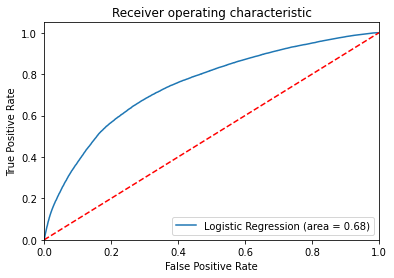

In [27]:
#Create ROC curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
#Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.4225121912160114


In [29]:
#results based on optimal threshold
THRESHOLD = optimal_threshold
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

(259153, 105566, 6650, 13497)

In [30]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82    364719
           1       0.11      0.67      0.19     20147

    accuracy                           0.71    384866
   macro avg       0.54      0.69      0.51    384866
weighted avg       0.93      0.71      0.79    384866



Here, we also tried to optimise the Logistic Regression model by C or regularisation parameter, and penalty term, to see if we can further improve on the results. The larger the value of C, the higher the tolerance for misclassification. 

In [31]:
params = {
    "C": [0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet", "none"]
}
model = LogisticRegression(solver ='saga') #saga supports all penalty and faster for large dataset
logreg = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
logreg.fit(os_data_X, os_data_y)
logreg.best_estimator_

/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.74828288 0.74828267        nan 0.74828254 0.74828287 0.74828255
        nan 0.74828292 0.74828287 0.74828266        nan 0.74828292
 0.74828302 0.74828283        nan 0.74828299 0.74828273 0.74828264
        nan 0.74828274 0.74828297 0.74828272        nan 0.74828281]
  warnings.warn(
/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/lilyn199/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=100, solver='saga')

In [32]:
y_pred = logreg.predict(X_test)

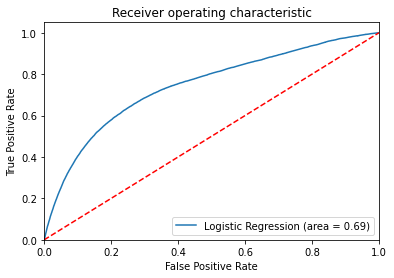

In [33]:
#Create ROC curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
#find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.5008915719078164


In [35]:
#results based on optimal threshold
THRESHOLD = optimal_threshold
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

(266359, 98360, 6895, 13252)

In [36]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.73      0.84    364719
           1       0.12      0.66      0.20     20147

    accuracy                           0.73    384866
   macro avg       0.55      0.69      0.52    384866
weighted avg       0.93      0.73      0.80    384866



As observed above, the results from our parameters tuning are similar to if we just use the default parameters. Hence, this might not be needed when running on the full dataset given the time it took to tune these parameters on large dataset.

### 2. XGBoost

Next, we tried a gradiant boosting machine learning method called XGBoost (extreme Gradient Boosting), which is an implementation of gradiant boosted decision trees. Boosting is an ensemble method, where models are added consecutively to improve accuracy of the previous ones, and gradient boosting uses gradient descent algorithm to minimise the loss when adding new models. 

XGBoost is popular as it provides results with high accuracy in both classification and regression problems. Before implementing XGBoost, we will tune 4 of its parameters:
1. *n_estimators*: number of estimators when boosting is terminated. 
2. *max_depth*: maximum depth of a tree. Higher value can make the tree overfit
3. *gamma*: minimum loss reduction required to make partition on a leaf node of the tree. the higher value of gamma, the more conservative the algorithm will be

To tune these parameters, we will use *GridSearchCV()* which performs exhaustive search over specified parameter values for a model. It works by cross-validating grid-search over parameter grid.

In [73]:
#splitting data into training and test set
X = test.drop("Buy", axis=1)
y = test["Buy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [74]:
## XGB - number of estimators
param_test = {'n_estimators': range(1,100,4)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', learning_rate=0.2, scale_pos_weight = 18,
                                                  use_label_encoder =False, eval_metric = 'auc'), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

{'n_estimators': 53}

In [39]:
## XGB - maximum tree depth
param_test2 = {'max_depth':range(1,10,2)}
gsearch2 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', scale_pos_weight = 18,
                                                  n_estimators = gsearch1.best_params_['n_estimators'], 
                                                  learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc'), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch2.fit(X_train, y_train)
gsearch2.best_params_

{'max_depth': 5}

In [40]:
#tuning gamma parameter
param_test3 = {'gamma': [i/10.0 for i in range(0,5)]} 
gsearch3 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', scale_pos_weight = 18,
                                                  n_estimators = gsearch1.best_params_['n_estimators'], 
                                                  learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                  max_depth = gsearch2.best_params_['max_depth']), 
                        param_grid = param_test3, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch3.fit(X_train, y_train)
gsearch3.best_params_

{'gamma': 0.0}

In our final model, we will also specify the scale_post_weight value, which is the ratio between class 0 and 1 at 18.

In [55]:
## Tuned model
XGB_model = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], 
                          max_depth = gsearch2.best_params_['max_depth'],gamma = gsearch3.best_params_['gamma'], 
                          scale_pos_weight = 18, n_jobs=-1, learning_rate = 0.2, 
                          #we need to account for imbalance class ratio 1:17.98 using scale_pos_weight
                          use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(X_train, y_train)
XGB_model_predict = XGB_model.predict(X_test)
XGB_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=85, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=17.98, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [56]:
print('XGB Test Accuracy:', accuracy_score(y_test, XGB_model_predict), '\n')
print(classification_report(y_test, XGB_model_predict))
print(confusion_matrix(y_test, XGB_model_predict), '\n')

XGB Test Accuracy: 0.740161510759589 

              precision    recall  f1-score   support

           0       0.98      0.74      0.84    364719
           1       0.13      0.72      0.22     20147

    accuracy                           0.74    384866
   macro avg       0.56      0.73      0.53    384866
weighted avg       0.93      0.74      0.81    384866

[[270429  94290]
 [  5713  14434]] 



### 3. CatBoost

Since XGBoost is performing well, we tried to run another gradient boosting method, called CatBoost, whose performance is often compared with Light GBM and XGBoost. It can in some cases, performs just as well as XGBoost, at a much faster rate (as expected from the cat family). To XGBoost's credit, it is older as was developed in 2014 compared to CatBoost in 2017.

To implement CatBoost, we will tune its *iterations* parameter, which is the maximum number of trees. We will also specify the class_weights or ratio between the 2 classes. 

In [7]:
X = test.drop("Buy", axis=1)
y = test["Buy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
params = {'iterations': range(50, 500, 50)}

model = CatBoostClassifier(eval_metric='AUC', learning_rate = 0.2, class_weights=[1, 18])
ctb = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, scoring ='roc_auc', refit =True)
ctb.fit(X_train, y_train)
y_pred = ctb.predict(X_test)

0:	total: 214ms	remaining: 31.9s
1:	total: 357ms	remaining: 26.4s
2:	total: 539ms	remaining: 26.4s
3:	total: 689ms	remaining: 25.1s
4:	total: 870ms	remaining: 25.2s
5:	total: 1.02s	remaining: 24.6s
6:	total: 1.21s	remaining: 24.8s
7:	total: 1.37s	remaining: 24.4s
8:	total: 1.55s	remaining: 24.3s
9:	total: 1.71s	remaining: 24s
10:	total: 1.9s	remaining: 24s
11:	total: 2.06s	remaining: 23.7s
12:	total: 2.24s	remaining: 23.6s
13:	total: 2.38s	remaining: 23.1s
14:	total: 2.55s	remaining: 23s
15:	total: 2.71s	remaining: 22.7s
16:	total: 2.89s	remaining: 22.6s
17:	total: 3.05s	remaining: 22.4s
18:	total: 3.24s	remaining: 22.3s
19:	total: 3.39s	remaining: 22s
20:	total: 3.57s	remaining: 21.9s
21:	total: 3.73s	remaining: 21.7s
22:	total: 3.92s	remaining: 21.6s
23:	total: 4.08s	remaining: 21.4s
24:	total: 4.25s	remaining: 21.3s
25:	total: 4.4s	remaining: 21s
26:	total: 4.58s	remaining: 20.9s
27:	total: 4.75s	remaining: 20.7s
28:	total: 4.91s	remaining: 20.5s
29:	total: 5.07s	remaining: 20.3s
30

In [11]:
print(ctb.best_estimator_.get_all_params())
print(classification_report(y_test, y_pred), '\n')

{'nan_mode': 'Min', 'eval_metric': 'AUC', 'iterations': 150, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 18], 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'learning_rate': 0.20000000298023224, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimat

In [12]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(269873, 94846, 5637, 14510)

### 4. Light GBM

We apply the Light GBM method to compare its performance to XGBoost and CatBoost. It differs from XGBoost in which it construct trees using Gradient-Based One-Sided Sampling, which is a novel approach to sampling method and as it brings down the complexity in training the decision trees, it subsequently makes the algorithm much faster to run. 

To implement LightGBM, we will tune 2 of its parameters:
1. *n_estimators*: number of boosted trees to fit
2. *boosting_type*: boosting types
    * 'gbdt': gradient boosting decision tree   
    * 'dart': dropouts meet multiple additive regression trees    
    * 'goss': gradient-based one-side sampling  
    * 'rf': random forest

In [8]:
X = test.drop("Buy", axis=1)
y = test["Buy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
params = {'n_estimators': range(50, 500, 50),
         'boosting_type': ['gbdt', 'dart', 'goss', 'rf']}

model = LGBMClassifier(objective='binary', learning_rate = 0.2, scale_pos_weight=18)
lgbm = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, scoring ='roc_auc', refit =True)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.79979637 0.79960632 0.79885568 0.79775741 0.79672563 0.79559372
 0.79429898 0.7931219  0.79194581 0.79975816 0.80093253 0.8011798
 0.80152488 0.80147421 0.80136437 0.80120152 0.80103931 0.80073234
 0.79980574 0.79936134 0.79836386 0.7969707  0.79558737 0.79406084
 0.79255793 0.79120326 0.78968477        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


In [13]:
print(lgbm.best_estimator_)
print(classification_report(y_test, y_pred), '\n')

LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=200,
               objective='binary', scale_pos_weight=18)
              precision    recall  f1-score   support

           0       0.98      0.74      0.84    364719
           1       0.13      0.72      0.22     20147

    accuracy                           0.74    384866
   macro avg       0.56      0.73      0.53    384866
weighted avg       0.94      0.74      0.81    384866
 



In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(269802, 94917, 5653, 14494)

### 5. Neural Networks

Here, we tried Neural Networks method, which is superior at capturing complex relationships between varibles by searching through different models in its black box to find patterns. In its black box, there can be one or more linear or non-linear hidden layers. 

We will apply SMOTE to the data as there is no parameter to adjust for the imbalanced in data in *MLPClassifier*. Additionally, we need to normalise the data before running neural networks as it is sensitive to feature scaling. We also specify that it will train using 2 hidden layers as 1 or 2 should give a decent performance for most problems, and 14 as number of neurons as we have 14 features in our dataset. 

In [28]:
X = test.drop("Buy", axis=1)
y = test["Buy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
os = SMOTE(random_state = 42, n_jobs=-1)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns)
os_data_y = pd.DataFrame(data = os_data_y,columns = ['Buy'])
scaler = StandardScaler()
NN_Xtrain = scaler.fit_transform(os_data_X)
NN_Xtest = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes = (14, 14), max_iter = 100, solver='adam', alpha=0.1, activation='logistic') 
#2 hidden layers and 'adam' optimizer works well for large dataset
mlp.fit(NN_Xtrain, os_data_y)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=(14, 14),
              max_iter=100)

In [30]:
y_preds = mlp.predict(NN_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

           0       0.96      0.89      0.93    364719
           1       0.17      0.39      0.23     20147

    accuracy                           0.87    384866
   macro avg       0.57      0.64      0.58    384866
weighted avg       0.92      0.87      0.89    384866

(325689, 39030, 12338, 7809) 



### 6. Support Vector Machine (SVM)

Here, we tried a non-probabilistic classifier called Support Vector Machine (SVM). This method is effective in high dimensional space and can control overfitting using its regularisation term. Additionally, it can use different kernel tricks, like polynomial or radial basis function, to transform non-linear problems to linearly separable cases. 

*SVC()* from sklearn.svm package only works well for dataset with tens of thousands observations. Since our sample has over 100,000 observations, we will need to use *SGDClassifier()* or *LinearSVC()* instead to implement SVM. Here, we will use *SGDClassifier()* as it is more flexible and faster in some cases than *LinearSVC()*. 

We will explore different kernel approximations: linear and polynomial as they seem to work well from the results below, thus it's highly unlikely that radial basis function will be a good fit. Since it will take a longer time to tune the parameters using *GridSearchCV*, we will specify the parameters directly as below:
1. *max_iter*: the default maximum number of passes over training data is 1000. However, in the interest of time and computer limitations, we will use 100 
2. *loss*: we used hinge as it is a loss function typically used for training classifiers
3. *penalty*: we used l1 as our regularisation term as it might bring sparsity in our model by shrinking some feature coefficients to 0, which helps reducing its complexity while still reducing the model's variance
4. *class_weight*: even though our actual ratio is 1:18, after testing with a few weights, we found that 1:22 gives us better performance results, which is slightly higher than the original ratio
5. *alpha*: given that the default is 0.0001 and the higher the value, the stronger the regularisation, we chose alpha value at 0.01 so that it will penalises more when there is a misclassification

In [7]:
X = test.drop("Buy", axis=1)
y = test["Buy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [49]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

svm = SGDClassifier(max_iter=100, loss='hinge', n_jobs=-1, penalty='l1', alpha = 0.01, class_weight={0: 1, 1: 22})
#adjusting class weight to get better balance between recall rates for class 0 and class 1 
svm.fit(SVM_Xtrain, y_train)
y_preds = svm.predict(SVM_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

           0       0.97      0.76      0.85    364719
           1       0.13      0.64      0.21     20147

    accuracy                           0.75    384866
   macro avg       0.55      0.70      0.53    384866
weighted avg       0.93      0.75      0.82    384866

(276956, 87763, 7206, 12941) 



Here, we will transform the data to 2nd degree polynomial kernel before running *SGDClassifier* as 3rd degree polynomial did not fit well with the data.

In [12]:
poly_feature = PolynomialCountSketch(degree = 2, n_components = 140) #optimal n_components = 10*n_features
SVM_Xtrain = poly_feature.fit_transform(X_train)
SVM_Xtest = poly_feature.transform(X_test)

In [15]:
svm = SGDClassifier(max_iter=100, loss='hinge', n_jobs=-1, penalty='l1', alpha = 0.01, class_weight={0: 1, 1: 20})
#adjust alpha to vary recall rates 
svm.fit(SVM_Xtrain, y_train)
y_preds = svm.predict(SVM_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

           0       0.96      0.64      0.77    364719
           1       0.08      0.54      0.14     20147

    accuracy                           0.64    384866
   macro avg       0.52      0.59      0.45    384866
weighted avg       0.92      0.64      0.74    384866

(234401, 130318, 9187, 10960) 



### 7. Stacking Classifier

Stacking is an ensemble method that combines multiple base classification models predictions, then it uses a blending model to combine the prediction of the base models. Stacking can harness the capabilities of different models and improve performance than any single model in the ensemble. The base models can be complex and diverse, while the blending model is often simple as it only needs to provide a smooth interpretation of the predictions output by the base models. 

Here, we tried a combinations of models to see if we can improve their performances. SVM, CatBoost and Logistic Regression have highest performance from the results earlier. CatBoost was chosen over Light GBM and XGBoost even though they all have the same performance because CatBoost takes the shortest time to train. 

In [5]:
X = test.drop("Buy", axis=1)
y = test["Buy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
estimators = [('svm', make_pipeline(StandardScaler(), 
                                    SGDClassifier(max_iter=100, loss='hinge', n_jobs=-1, 
                                                  penalty='l1', alpha = 0.01, class_weight={0: 1, 1: 22}))),
              ('ctb', CatBoostClassifier(eval_metric='AUC', learning_rate = 0.2, class_weights=[1, 18], iterations=150)),
             ('lg', make_pipeline(StandardScaler(), LogisticRegression(C=1000, solver='saga', class_weight={0: 1, 1:22})))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    364719
           1       0.25      0.00      0.00     20147

    accuracy                           0.95    384866
   macro avg       0.60      0.50      0.49    384866
weighted avg       0.91      0.95      0.92    384866



### Summary

As observed above, Logistic Regression, XGBoost, CatBoost, Light GBM, and SVM did well in our sample dataset. Even though Logistic Regression did not do as well as the others mentioned, we will still implement it on our full dataset as it is easy to implement while giving considerably good results. 